# Tracking Evaluation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](ここに以下の書式でURLを入れる) 
[![github](https://badgen.net/badge/:status/View%20On%20Github/black?icon=github&label)](https://github.com/AtomScott/SoccerTrack)
[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=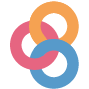)](https://)

---

This is a work in progress tutorial, more to come soon!

**Multiple Object Tracking Accuracy (MOTA)** is a measure of the overall accuracy of the tracker. It takes into account false positives, false negatives, and identity switches. A higher MOTA score indicates better performance.

**Multiple Object Tracking Precision (MOTP)** is a measure of the precision of the tracker in terms of the location of the tracked objects. It is calculated as the average distance between the predicted and ground truth object locations. A higher MOTP score indicates better performance.

**Most Tracked Objects (MT)** is the number of ground truth objects that are successfully tracked for at least 50% of the frames in which they appear. This metric gives an indication of how well the tracker is able to maintain object tracks.

**Most Lost Objects (ML)** is the number of ground truth objects that are not successfully tracked for at least 50% of the frames in which they appear. This metric gives an indication of how well the tracker is able to maintain object tracks.

**Fragmentation** is a measure of how many times the tracker switches between different ground truth objects. A higher fragmentation score indicates worse performance.

**Id-Switches** is the number of times the tracker switches the identity of a ground truth object with another ground truth object. This metric gives an indication of how well the tracker is able to maintain object identities.

In [3]:
%load_ext autoreload
%autoreload 2

from typing import Any

from soccertrack.metrics import mota_score, identity_score, hota_score
import soccertrack
from soccertrack import Camera

import numpy as np
# from scipy.spatial.distance import cdist
# from soccertrack.metrics import iou_score
# from soccertrack.logger import tqdm

from scipy.optimize import linear_sum_assignment

dataset_path = soccertrack.datasets.get_path('top-view')
path_to_csv = sorted(dataset_path.glob('annotations/*.csv'))[0]
path_to_mp4 = sorted(dataset_path.glob('videos/*.mp4'))[0]
bbdf = soccertrack.load_df(path_to_csv) # We will use this as ground truth

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Confirmation of Script Operation

In [4]:
bbdf_gt = bbdf
bbdf_track = bbdf
mota = mota_score(bbdf_gt,bbdf_track)

100%|██████████| 900/900 [00:01<00:00, 565.75it/s]


In [5]:
identity = identity_score(bbdf_gt,bbdf_track)
identity

Preprocessing for MOT evaluation: 100%|██████████| 900/900 [01:13<00:00, 12.21it/s]


{'IDF1': 1.0, 'IDR': 1.0, 'IDP': 1.0, 'IDTP': 20700, 'IDFN': 0, 'IDFP': 0}

In [6]:
hota = hota_score(bbdf_gt,bbdf_track)
hota

Preprocessing for MOT evaluation: 100%|██████████| 900/900 [01:13<00:00, 12.29it/s]


{'HOTA': 1.0,
 'DetA': 1.0,
 'AssA': 1.0,
 'DetRe': 1.0,
 'DetPr': 1.0,
 'AssRe': 1.0,
 'AssPr': 1.0,
 'LocA': 1.0,
 'RHOTA': 1.0,
 'HOTA_TP': 20700.0,
 'HOTA_FN': 0.0,
 'HOTA_FP': 0.0,
 'HOTA(0)': 1.0,
 'LocA(0)': 1.0,
 'HOTALocA(0)': 1.0}